<a href="https://colab.research.google.com/github/AsmaBenHmidene/anti-HIV-molecules-activity-and-lipophilicity-predictions/blob/main/anti_HIV_Active_Molecule_prediction_of_lipophilicity_of_small_organic_molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research problem and Objective:

Lipophilicity is a physical property of a substance that refers to an ability of a chemical compound to dissolve in lipids, oils and generally in non-polar solvents.

That's a fundamental property that plays great part in biochemical and technological behaviour of a substance. It's usually evaluated by a distribution coefficent P - the ratio of concentrations of a particular compound in a mixture of two immiscible phases at equilibrium (in our case water and octanol). The greater P values refer to greater lipophilicity. Usually lipophilicity is presented as log10P like in our dataset.

A thing important to mention is that it takes much time to perform an experiment to measure the corresponding P value, because it must be an exact and reproducible procedure repeated at least 3-5 times and each time you have to wait till the system's equilibrium is reached.

Lipophilicity is one of the factors determining the permeability of the cell membrane to a drug molecule. Hence, accurate lipophilicity prediction is an essential step in the development of new drugs and can be used to screen large libraries of potential therapeutics.

chemical insights: from theory P value must turn great when a molecule is large and doesn't have many polar atoms or atomic groups (such containing O, N, P, S, Br, Cl, F an etc.) in it.

# 1) Analysis of data:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Projects/mlchem project/logP_dataset.csv', names=['smiles', 'logP'], low_memory=False)
print(df.shape)
df.head()

(14610, 2)


,smiles,logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
4,CCCOCCP,0.6


The table contains only smiles as a features and the target logP. Having one feature is not enough for creating a model prediction.

In [4]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 48.0 MB/s eta 0:00:00


In [5]:
#Importing Chem module
from rdkit import Chem

#Method transforms smiles strings to mol rdkit object
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

#Now let's see what we've got
print(type(df['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


### Overview of some of the selected molecule to predict logP:

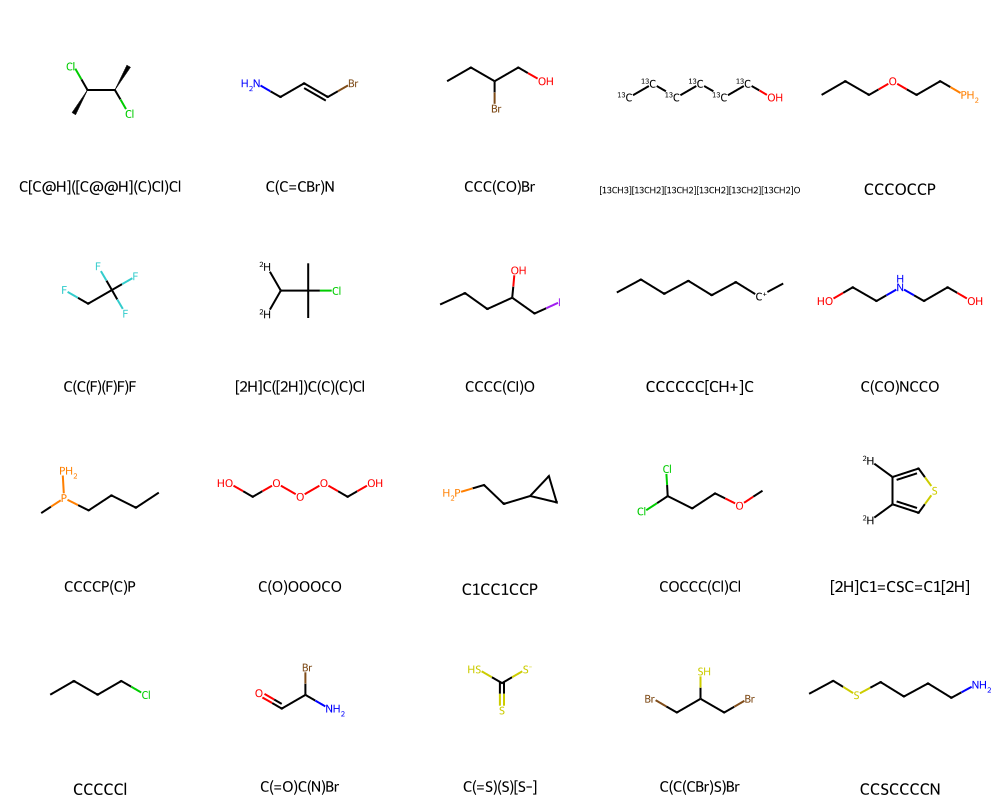

In [6]:
from rdkit.Chem import Draw
mols = df['mol'][:20]

#MolsToGridImage allows to paint a number of molecules at a time
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(df['smiles'][:20].values))

We can also extract some ring information or iterate through each molecule's atoms and bonds with RDkit. Methods GetRingInfo(), GetAtoms() and GetBonds() yield corresponding generators over rings and atoms in molecule.

Some toy examples:

In [7]:
m = Chem.MolFromSmiles('C(=O)C(=N)CCl')

In [8]:
# Getting number of rings with specified number of backbones
print('Number of rings with 1 backbone:', m.GetRingInfo().NumAtomRings(1))
print('Number of rings with 2 backbones:', m.GetRingInfo().NumAtomRings(2))

Number of rings with 1 backbone: 0
Number of rings with 2 backbones: 0


In [9]:
#Iterating through atoms to get atom symbols and explicit valencies
for atom in m.GetAtoms():
    print('Atom:', atom.GetSymbol(), 'Valence:', atom.GetExplicitValence())

Atom: C Valence: 3
Atom: O Valence: 2
Atom: C Valence: 4
Atom: N Valence: 2
Atom: C Valence: 2
Atom: Cl Valence: 1


### Adding more features:

RDkit provides GetNumAtoms() and GetNumHeavyAtoms() methods for this task.

In [10]:
# AddHs function adds H atoms to a MOL (as Hs in SMILES are usualy ignored)
# GetNumAtoms() method returns a general nubmer of all atoms in a molecule
# GetNumHeavyAtoms() method returns a nubmer of all atoms in a molecule with molecular weight > 1


df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
df

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362960>,14,6
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7e0bd93629d0>,11,5
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362a40>,15,6
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362ab0>,21,7
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362b20>,20,7
...,...,...,...,...,...
14605,CCC(SC)Br,2.7,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b21690>,15,6
14606,[2H]C([2H])([C@@H](CO)O)O,-1.8,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b21700>,14,6
14607,CC(C)NNC,0.4,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b21770>,18,6
14608,C[C@H]1CCC[CH]1,3.4,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b217e0>,17,6


The next step is to count numbers of the most common atoms. RDkit supports subpattern search represented by GetSubstructMatches() method. It takes a MOL of a substructure pattern as an argument. So you can futher extract occurance of each pattern you'd like.

In [11]:
# First we need to settle the pattern.
c_patt = Chem.MolFromSmiles('C')

# Now let's implement GetSubstructMatches() method
print(df['mol'][0].GetSubstructMatches(c_patt))

((0,), (1,), (2,), (3,))


In [12]:
#We're going to settle the function that searches patterns and use it for a list of most common atoms only
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl','Br','S','P'], df)
df

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_S_atoms,num_of_P_atoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362960>,14,6,4,0,0,2,0,0,0
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7e0bd93629d0>,11,5,3,0,1,0,1,0,0
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362a40>,15,6,4,1,0,0,1,0,0
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362ab0>,21,7,6,1,0,0,0,0,0
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362b20>,20,7,5,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14605,CCC(SC)Br,2.7,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b21690>,15,6,4,0,0,0,1,1,0
14606,[2H]C([2H])([C@@H](CO)O)O,-1.8,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b21700>,14,6,3,3,0,0,0,0,0
14607,CC(C)NNC,0.4,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b21770>,18,6,4,0,2,0,0,0,0
14608,C[C@H]1CCC[CH]1,3.4,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b217e0>,17,6,6,0,0,0,0,0,0


### Pairplot between some features and the target 'logP':

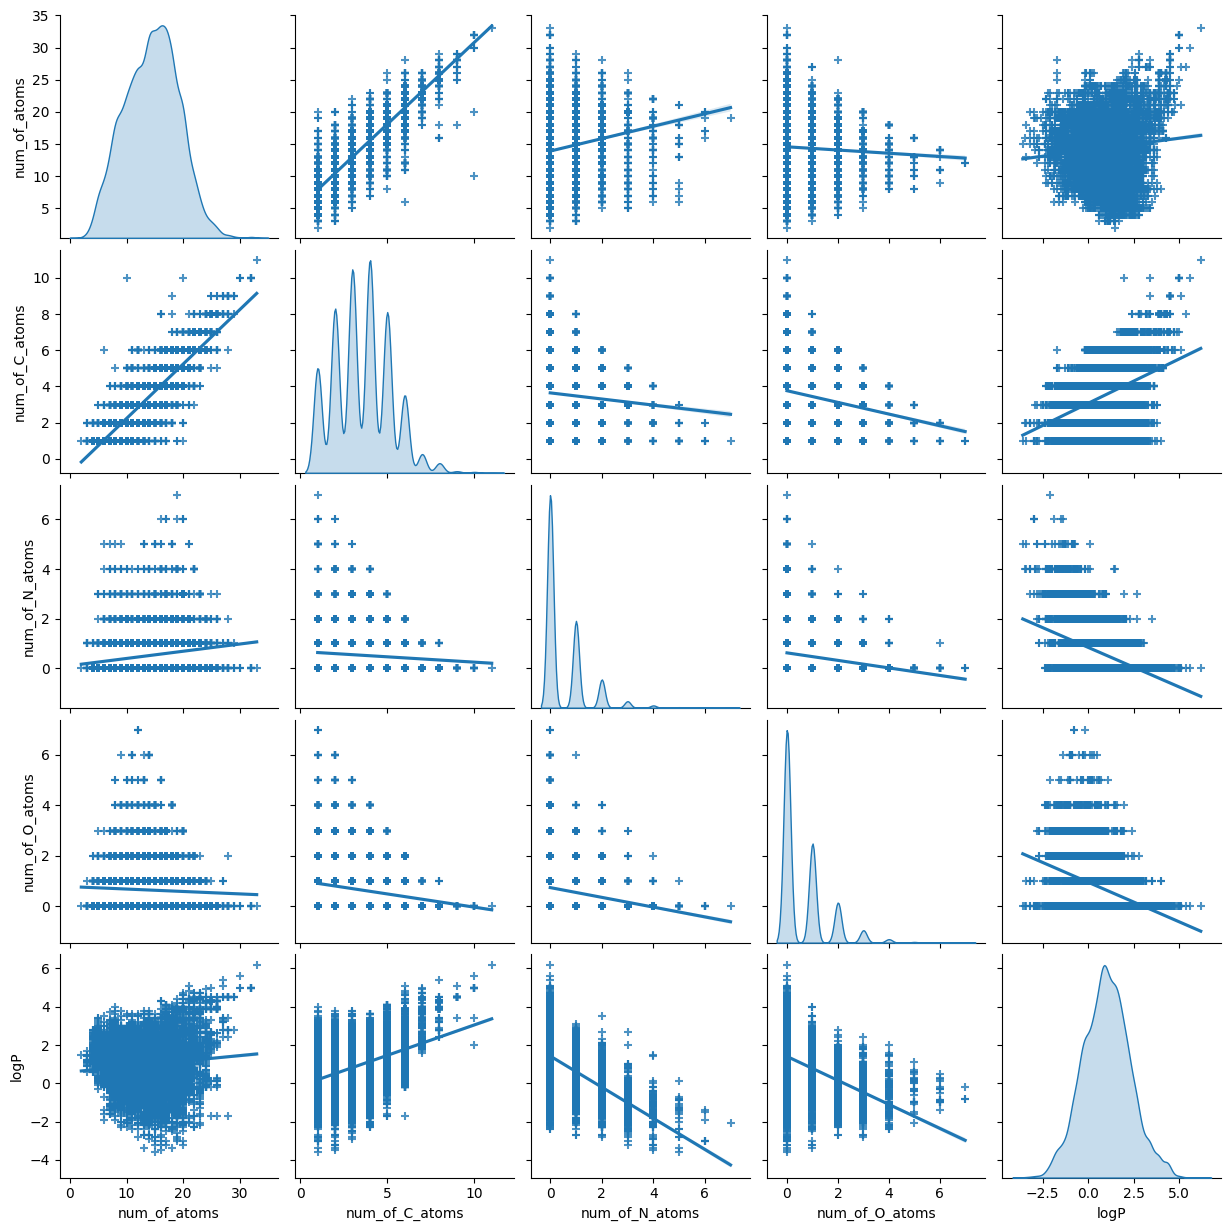

In [13]:
sns.pairplot(df[['num_of_atoms','num_of_C_atoms','num_of_N_atoms', 'num_of_O_atoms', 'logP']], diag_kind='kde', kind='reg', markers='+')
plt.show()

Looking at the bottom plots we notice some linear dependence of logP on numbers of particular atoms. We also see normal distribution of the target variable which values lie approximately from -5 to 5.

Let's build our first model. We'll count on linear regression.

# 2) Prediction Model:

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
#Identify the features (X) and target (y)
y = df['logP']
X1 = df.drop(columns=['logP','smiles','mol'])

In [16]:
#Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X1,y,random_state=42)
X_train.head()

,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_S_atoms,num_of_P_atoms
11054,11,5,3,1,0,0,0,1,0
591,15,6,3,2,1,0,0,0,0
7885,22,7,6,0,1,0,0,0,0
5489,8,4,2,0,0,0,0,0,0
9069,12,6,2,3,0,0,0,1,0


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
lin_reg = LinearRegression()

In [18]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [19]:
# Get predictions for the training data
y_predictions_train = lin_reg.predict(X_train)
# Get predictions for the testing data
y_predictions_test = lin_reg.predict(X_test)

In [20]:
train_r2 = r2_score(y_train, y_predictions_train)
test_r2 = r2_score(y_test, y_predictions_test)
print(f'Training R2: {train_r2:.3f}')
print(f'Testing R2: {test_r2:.3f}')

Training R2: 0.723
Testing R2: 0.724


In [21]:
train_MSE = mean_squared_error(y_train,  y_predictions_train)
test_MSE = mean_squared_error(y_test, y_predictions_test)
print(f'Training MSE: {train_MSE:,.2f}')
print(f'Testing MSE: {test_MSE:,.2f}')

Training MSE: 0.47
Testing MSE: 0.47


In [22]:
train_MAE = mean_absolute_error(y_train,  y_predictions_train)
test_MAE = mean_absolute_error(y_test, y_predictions_test)
print(f'Training MAE: {train_MAE:,.2f}')
print(f'Testing MAE: {test_MAE:,.2f}')

Training MAE: 0.53
Testing MAE: 0.53


### Adding extra features using rdkit.Chem.Descriptors:

rdkit.Chem.Descriptors provides a number of general molecular descriptors that can also be used to featurize a molecule. Most of the descriptors are straightforward to use from Python.

Using this package we can add some useful features to our model:

rdkit.Chem.Descriptors.TPSA() - the surface sum over all polar atoms or molecules also including their attached hydrogen atoms;

rdkit.Chem.Descriptors.ExactMolWt() - exact molecural weight;

rdkit.Chem.Descriptors.NumValenceElectrons() - number of valence electrons (may illustrate general electronic density)

rdkit.Chem.Descriptors.NumHeteroatoms() - general number of non-carbon atoms

In [23]:
from rdkit.Chem import Descriptors
df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))
df

,smiles,logP,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_S_atoms,num_of_P_atoms,tpsa,mol_w,num_valence_electrons,num_heteroatoms
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362960>,14,6,4,0,0,2,0,0,0,0.00,126.000306,38,2
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7e0bd93629d0>,11,5,3,0,1,0,1,0,0,26.02,134.968361,30,2
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362a40>,15,6,4,1,0,0,1,0,0,20.23,151.983677,38,2
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362ab0>,21,7,6,1,0,0,0,0,0,20.23,108.124594,44,1
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7e0bd9362b20>,20,7,5,1,0,0,0,0,1,9.23,120.070402,44,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,CCC(SC)Br,2.7,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b21690>,15,6,4,0,0,0,1,1,0,0.00,167.960833,38,2
14606,[2H]C([2H])([C@@H](CO)O)O,-1.8,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b21700>,14,6,3,3,0,0,0,0,0,60.69,94.059898,38,3
14607,CC(C)NNC,0.4,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b21770>,18,6,4,0,2,0,0,0,0,24.06,88.100048,38,2
14608,C[C@H]1CCC[CH]1,3.4,<rdkit.Chem.rdchem.Mol object at 0x7e0bd8b217e0>,17,6,6,0,0,0,0,0,0,0.00,83.086075,35,0


In [24]:
#Identify the features (X) and target (y)
y = df['logP']
X_mod = df.drop(columns=['logP','smiles','mol'])

In [25]:
#Perform a train test split
X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(X_mod,y,random_state=42)

In [26]:
lin_reg.fit(X_train_mod, y_train)

LinearRegression()

In [27]:
# Get predictions for the training data
y_predictions_train = lin_reg.predict(X_train_mod)
# Get predictions for the testing data
y_predictions_test = lin_reg.predict(X_test_mod)

In [28]:
train_r2 = r2_score(y_train_mod, y_predictions_train)
test_r2 = r2_score(y_test_mod, y_predictions_test)
print(f'Training R2: {train_r2:.3f}')
print(f'Testing R2: {test_r2:.3f}')

Training R2: 0.787
Testing R2: 0.787


In [29]:
train_MSE = mean_squared_error(y_train_mod,  y_predictions_train)
test_MSE = mean_squared_error(y_test_mod, y_predictions_test)
print(f'Training MSE: {train_MSE:,.2f}')
print(f'Testing MSE: {test_MSE:,.2f}')

Training MSE: 0.36
Testing MSE: 0.36


In [30]:
train_MAE = mean_absolute_error(y_train_mod,  y_predictions_train)
test_MAE = mean_absolute_error(y_test_mod, y_predictions_test)
print(f'Training MAE: {train_MAE:,.2f}')
print(f'Testing MAE: {test_MAE:,.2f}')

Training MAE: 0.45
Testing MAE: 0.46


RDkit is a wonderful tool to work with chemical data, especially represented as SMILES strings or in MOL format.

# 3) Improving model performance using mol2vec:

Trying to improve our model perfomance at the next step, we'll take a look at a completely different way to featurize molecules.

mol2vec - learning vector representations of molecular subctructures
From package description 'Mol2vec is an unsupervised machine learning approach to obtain high dimensional embeddings of chemical substructures. It is based on word2vec algorithm and if word2vec learns such embeddings that vectors representing similar words group together, so should Mol2vec learn substructure embeddings where vectors of chemically related substructures end up close in vector space'.

In other words mol2vec takes inspiration in one of the most widespread NLP technique. Without going deep in detaials we can describe the process as following:

1. A molecule is divided into substructures of a fixed radius (usually encoding distance to other atoms in bonds, i.e. radius = 1 represents a single heavy atom or a group of closest atoms around a heavy atom), substructures are encoded via Morgan fingerprints with the help of RDkit. Substructures reflect words in 'chemical sentences'.

2. These encoded substructures are fed to Word2vec yielding vector representations of substructures in a number of dimensions according to their occurance together.

3. Summing up substructure vectors we get vector representations of whole molecules.

The main idea behind is that we can use vector representations of molecules in different dimensions as features in supervised learning, supposing similar molecules will have close vector representations and will have close target values.

Another wonderful point is that mol2vec provides a pre-trained model which has learned 20M different compounds with radius=1 for Morgan fingerprints.

In [31]:
#Installing a package
!pip install git+https://github.com/samoturk/mol2vec;

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-a0razcj_
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /tmp/pip-req-build-a0razcj_
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14016 sha256=dddfb63a3a8ba60ebefb114428ee9a058565e5914b353df90232d85842283731
  Stored in directory: /tmp/pip-ephem-wheel-cache-oodd5g4j/wheels/b9/bd/e0/b6dd7c5e346247e8d6944e08ca1c262a908231747f4efa539d
Successfully built mol2vec


In [32]:
#Load the dataset and extract target values
mdf= pd.read_csv('/content/drive/MyDrive/Projects/mlchem project/logP_dataset.csv', names=['smiles',
                                           'target'])
target = mdf['target']
mdf.drop(columns='target',inplace=True)
mdf

,smiles
0,C[C@H]([C@@H](C)Cl)Cl
1,C(C=CBr)N
2,CCC(CO)Br
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O
4,CCCOCCP
...,...
14605,CCC(SC)Br
14606,[2H]C([2H])([C@@H](CO)O)O
14607,CC(C)NNC
14608,C[C@H]1CCC[CH]1


In [33]:
#Transforming SMILES to MOL
mdf['mol'] = mdf['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
mdf

,smiles,mol
0,C[C@H]([C@@H](C)Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7e0bcc64b220>
1,C(C=CBr)N,<rdkit.Chem.rdchem.Mol object at 0x7e0bcc64b300>
2,CCC(CO)Br,<rdkit.Chem.rdchem.Mol object at 0x7e0bcc64b450>
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,<rdkit.Chem.rdchem.Mol object at 0x7e0bcc64b4c0>
4,CCCOCCP,<rdkit.Chem.rdchem.Mol object at 0x7e0bcc64b530>
...,...,...
14605,CCC(SC)Br,<rdkit.Chem.rdchem.Mol object at 0x7e0bcc4ca1f0>
14606,[2H]C([2H])([C@@H](CO)O)O,<rdkit.Chem.rdchem.Mol object at 0x7e0bcc4ca260>
14607,CC(C)NNC,<rdkit.Chem.rdchem.Mol object at 0x7e0bcc4ca2d0>
14608,C[C@H]1CCC[CH]1,<rdkit.Chem.rdchem.Mol object at 0x7e0bcc4ca340>


In [34]:
#Loading pre-trained model via word2vec
from gensim.models import word2vec
model = word2vec.Word2Vec.load('/content/drive/MyDrive/Projects/mlchem project/model_300dim.pkl')

Importing necessary functions.

mol2alt_sentence() constructs a so-called 'molecular sentence' with desired Morgan fingerprints' radius (uses RDkit backend) where 'words' are unique substructure identifiers; MolSentence() is an internal wrapper function; sentences2vec() generates molecular embeddings with the help of the trained model; DfVec() is an internal wrapper for embeddings' generator (attribute .vec yields aggregated vectors).

In [35]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
print('Molecular sentence:', mol2alt_sentence(mdf['mol'][1], radius=1))
print('\nMolSentence object:', MolSentence(mol2alt_sentence(mdf['mol'][1], radius=1)))

Molecular sentence: ['2245384272', '772923822', '2246703798', '530246988', '2246703798', '1211882010', '3612926680', '318583445', '847957139', '2592785365']

MolSentence object: MolSentence with 10 words


In [36]:
def sentences2vec(sentences, model, unseen='UNK'):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [37]:
A = mol2alt_sentence(mdf['mol'][1], radius=1)
B = MolSentence(A)
C = sentences2vec(B, model, unseen='UNK')
print('\nDfVec object:',DfVec(C))


DfVec object: (10, 300) dimensional vector


Now let's implement those functions above and construct a feature matrix of vector representations.

In [38]:
#Constructing sentences
mdf['sentence'] = mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures

mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(mdf['sentence'], model, unseen='UNK')]
X = np.array([x.vec for x in mdf['mol2vec']])
y = target.values

In [39]:
X

array([[-0.224565  , -1.3119394 , -1.3232803 , ...,  0.25521812,
        -0.885902  , -0.14283316],
       [-1.0952972 ,  0.47649723, -2.771055  , ..., -1.9937197 ,
        -2.5221841 , -1.815909  ],
       [ 0.47723693,  0.8729614 , -1.3119761 , ..., -3.9490411 ,
        -1.7616985 , -1.0649242 ],
       ...,
       [-0.8703902 ,  0.39318347, -0.16090018, ..., -2.2809882 ,
        -2.1042633 , -0.7777686 ],
       [ 0.3707652 , -0.8037348 , -0.67864734, ..., -1.6128515 ,
        -3.066814  ,  0.6305967 ],
       [ 1.148132  , -0.75136757, -0.7392227 , ..., -3.3428202 ,
        -2.4159865 ,  0.7404512 ]], dtype=float32)

In [40]:
X.shape

(14610, 300)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [42]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [43]:
# Get predictions for the training data
y_predictions_train = lin_reg.predict(X_train)
# Get predictions for the testing data
y_predictions_test = lin_reg.predict(X_test)

In [44]:
train_r2 = r2_score(y_train, y_predictions_train)
test_r2 = r2_score(y_test, y_predictions_test)
print(f'Training R2: {train_r2:.3f}')
print(f'Testing R2: {test_r2:.3f}')

Training R2: 0.891
Testing R2: 0.889


In [45]:
train_MSE = mean_squared_error(y_train,  y_predictions_train)
test_MSE = mean_squared_error(y_test, y_predictions_test)
print(f'Training MSE: {train_MSE:,.2f}')
print(f'Testing MSE: {test_MSE:,.2f}')

Training MSE: 0.18
Testing MSE: 0.19


In [46]:
train_MAE = mean_absolute_error(y_train,  y_predictions_train)
test_MAE = mean_absolute_error(y_test, y_predictions_test)
print(f'Training MAE: {train_MAE:,.2f}')
print(f'Testing MAE: {test_MAE:,.2f}')

Training MAE: 0.30
Testing MAE: 0.31


In [47]:
mdf = pd.DataFrame(X)
new_df = pd.concat((mdf, X1), axis=1)
new_df

,0,1,2,3,4,5,6,7,8,9,...,299,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_S_atoms,num_of_P_atoms
0,-0.224565,-1.311939,-1.323280,0.342851,-0.550690,0.526764,1.377086,-0.280362,3.417280,-0.929851,...,-0.142833,14,6,4,0,0,2,0,0,0
1,-1.095297,0.476497,-2.771055,0.809915,1.586082,0.585418,-2.933355,-1.595552,0.202827,-0.266954,...,-1.815909,11,5,3,0,1,0,1,0,0
2,0.477237,0.872961,-1.311976,-0.161034,1.433220,0.687261,-1.604110,0.305157,1.272478,-1.288493,...,-1.064924,15,6,4,1,0,0,1,0,0
3,-0.157045,-0.806873,-0.176573,-0.550286,2.925699,1.280460,-4.271525,-0.977116,1.338565,-2.654734,...,-2.811765,21,7,6,1,0,0,0,0,0
4,-0.188814,-0.269751,-0.320993,0.214247,2.722344,1.731028,-3.780885,-1.127597,1.978434,-2.255132,...,-1.928494,20,7,5,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,0.323151,0.854803,-0.123054,1.256199,1.040276,0.103222,-2.156345,-0.123552,1.855156,-1.230662,...,-0.222462,15,6,4,0,0,0,1,1,0
14606,1.771019,1.166876,-0.418851,0.744797,0.945885,-0.097961,-4.884740,1.471506,1.320957,0.177879,...,0.535163,14,6,3,3,0,0,0,0,0
14607,-0.870390,0.393183,-0.160900,0.615402,0.946424,0.373759,-2.278427,-2.301465,4.139015,-0.656254,...,-0.777769,18,6,4,0,2,0,0,0,0
14608,0.370765,-0.803735,-0.678647,1.373099,-0.547684,-1.671074,-2.022421,0.760693,1.204176,0.070424,...,0.630597,17,6,6,0,0,0,0,0,0


In [48]:
new_df.columns = new_df.columns.astype(str)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=.2, random_state=1)

In [50]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [51]:
# Get predictions for the training data
y_predictions_train = lin_reg.predict(X_train)
# Get predictions for the testing data
y_predictions_test = lin_reg.predict(X_test)

In [52]:
train_r2 = r2_score(y_train, y_predictions_train)
test_r2 = r2_score(y_test, y_predictions_test)
print(f'Training R2: {train_r2:.3f}')
print(f'Testing R2: {test_r2:.3f}')

Training R2: 0.924
Testing R2: 0.920


In [53]:
train_MSE = mean_squared_error(y_train,  y_predictions_train)
test_MSE = mean_squared_error(y_test, y_predictions_test)
print(f'Training MSE: {train_MSE:,.2f}')
print(f'Testing MSE: {test_MSE:,.2f}')

Training MSE: 0.13
Testing MSE: 0.13


In [54]:
train_MAE = mean_absolute_error(y_train,  y_predictions_train)
test_MAE = mean_absolute_error(y_test, y_predictions_test)
print(f'Training MAE: {train_MAE:,.2f}')
print(f'Testing MAE: {test_MAE:,.2f}')

Training MAE: 0.25
Testing MAE: 0.26
